In [1]:
import scanpy as sc
import pandas as pd
import sys
import os
import numpy as np
import pandas as pd
import scib
from scib_metrics.benchmark import Benchmarker
from harmony import harmonize
from rich import print
import matplotlib.pyplot as plt
%matplotlib inline

# Batch correction: RxRx19b, HUVEC

For more information on the dataset please see: https://www.rxrx.ai/rxrx19b and https://github.com/theislab/batch_correction_cellpainting/blob/feat/rxrx1_huvec_exploration/data/rxrx19b/rxrx19b_overview.md <br>

* [I. Batch correction](#batch)
    * [A. Read in the data](#batch_sub1)
    * [B. Run harmony metric from scIB](#batch_sub2)
    * [C. Plot UMAP before and after batch correction](#batch_sub3)

### A. Read in the data <a class="anchor" id="vis_sub1"></a>

Read in the embeddings and add metadata to adata.obs + add well row & column to the metadata:

In [2]:
meta_file = "../../data/rxrx19b/metadata.csv"
embedding_file = "../../data/rxrx19b/embeddings.csv"
if not os.path.exists(meta_file):
    raise FileNotFoundError("Please download the metadata from https://www.rxrx.ai/rxrx19b and put the file metadata.csv in the directory data/rxrx19b")
if not os.path.exists(embedding_file):
    raise FileNotFoundError("Please download the embeddings from https://www.rxrx.ai/rxrx19b and put the file embeddings.csv in the directory data/rxrx19b")

In [3]:
adata = sc.read_csv(embedding_file)
meta = pd.read_csv(meta_file, index_col = 0)
# change the order of the rows in the meta data to match the order in the embeddings
meta = meta.reindex(pd.read_csv(embedding_file, index_col = 0).index)
adata.obs = meta
# Split 'well' column into 'well_row' and 'well_column'
adata.obs[['well_row', 'well_column']] = adata.obs['well'].str.extract(r'([A-Z]+)(\d+)')
# Replace NaN values with "blank" in a specific column
adata.obs['disease_condition'] = adata.obs['disease_condition'].fillna("blank")
print(adata)
meta.tail(n=5)

AnnData object with n_obs × n_vars = 70384 × 128
    obs: 'well_id', 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 
'treatment_conc', 'SMILES', 'well_row', 'well_column'

,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,well_row,well_column
site_id,,,,,,,,,,,,
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,Z,42
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,Z,43
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",Z,45
HUVEC-1_9_Z46_1,HUVEC-1_9_Z46,HUVEC,HUVEC-1,9,Z46,1,storm-severe,tilmicosin,0.025,CC[C@@H]1OC(=O)C[C@@H](O)[C@H](C)[C@@H](O[C@@H...,Z,46
HUVEC-1_9_Z47_1,HUVEC-1_9_Z47,HUVEC,HUVEC-1,9,Z47,1,storm-severe,Itopride,0.025,COC1=C(OC)C=C(C=C1)C(=O)NCC1=CC=C(OCCN(C)C)C=C...,Z,47


### Run harmony metric from scIB<a class="anchor" id="vis_sub1"></a>

Harmony provides a batch correction algorithm that uses a graph-based approach to preserve the local structure of the data.

In [4]:
adata.obs['plate'] = adata.obs['plate'].astype('category')
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="plate")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

In [5]:
#Subset to highly variable genes
adata = adata[:, adata.var.highly_variable].copy()

In [6]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [7]:
#Run harmony
adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="plate")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [8]:
#Run benchmark
bm = Benchmarker(
    adata,
    batch_key="plate",
    label_key="disease_condition",
    embedding_obsm_keys=["Unintegrated", "Harmony"],
    n_jobs=6,
)
bm.benchmark()

Computing neighbors:   0%|                                                                        | 0/2 [00:00<?, ?it/s]/home/mahim/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mahim/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

INFO     blank consists of a single batch or is too small. Skip.                                                   



Metrics:  80%|████████████████████████████████▊        | 8/10 [02:49<01:07, 33.77s/it, Batch correction: pcr_comparison]/home/mahim/.local/lib/python3.8/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(

Metrics:   0%|                                                                                   | 0/10 [00:00<?, ?it/s]
                                                                                                                        
Metrics:  60%|████████████████████████▌                | 6/10 [01:38<00:56, 14.18s/it, Batch correction: kbet_per_label]

INFO     blank consists of a single batch or is too small. Skip.                                                   



Embeddings: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [06:02<00:00, 181.19s/it]

                                                                                                                        

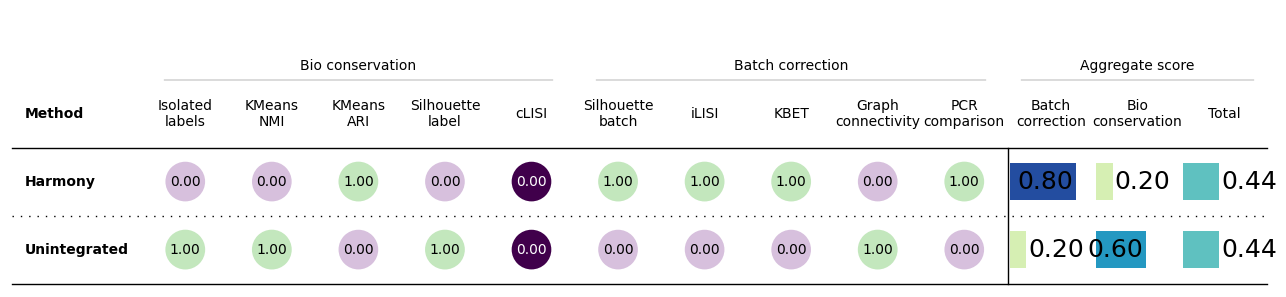

In [9]:
bm.plot_results_table()

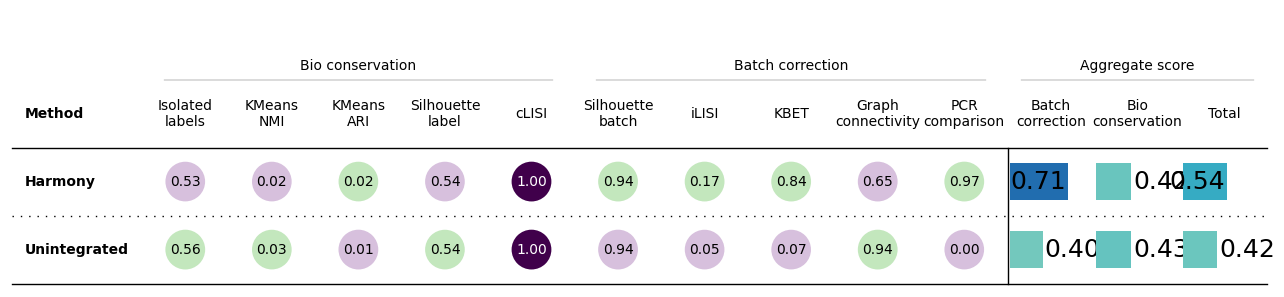

In [10]:
bm.plot_results_table(min_max_scale=False)

In [11]:
df = bm.get_results(min_max_scale=False)
#print(df)
#df.transpose()

### Plot UMAP before and after batch correction<a class="anchor" id="vis_sub1"></a>

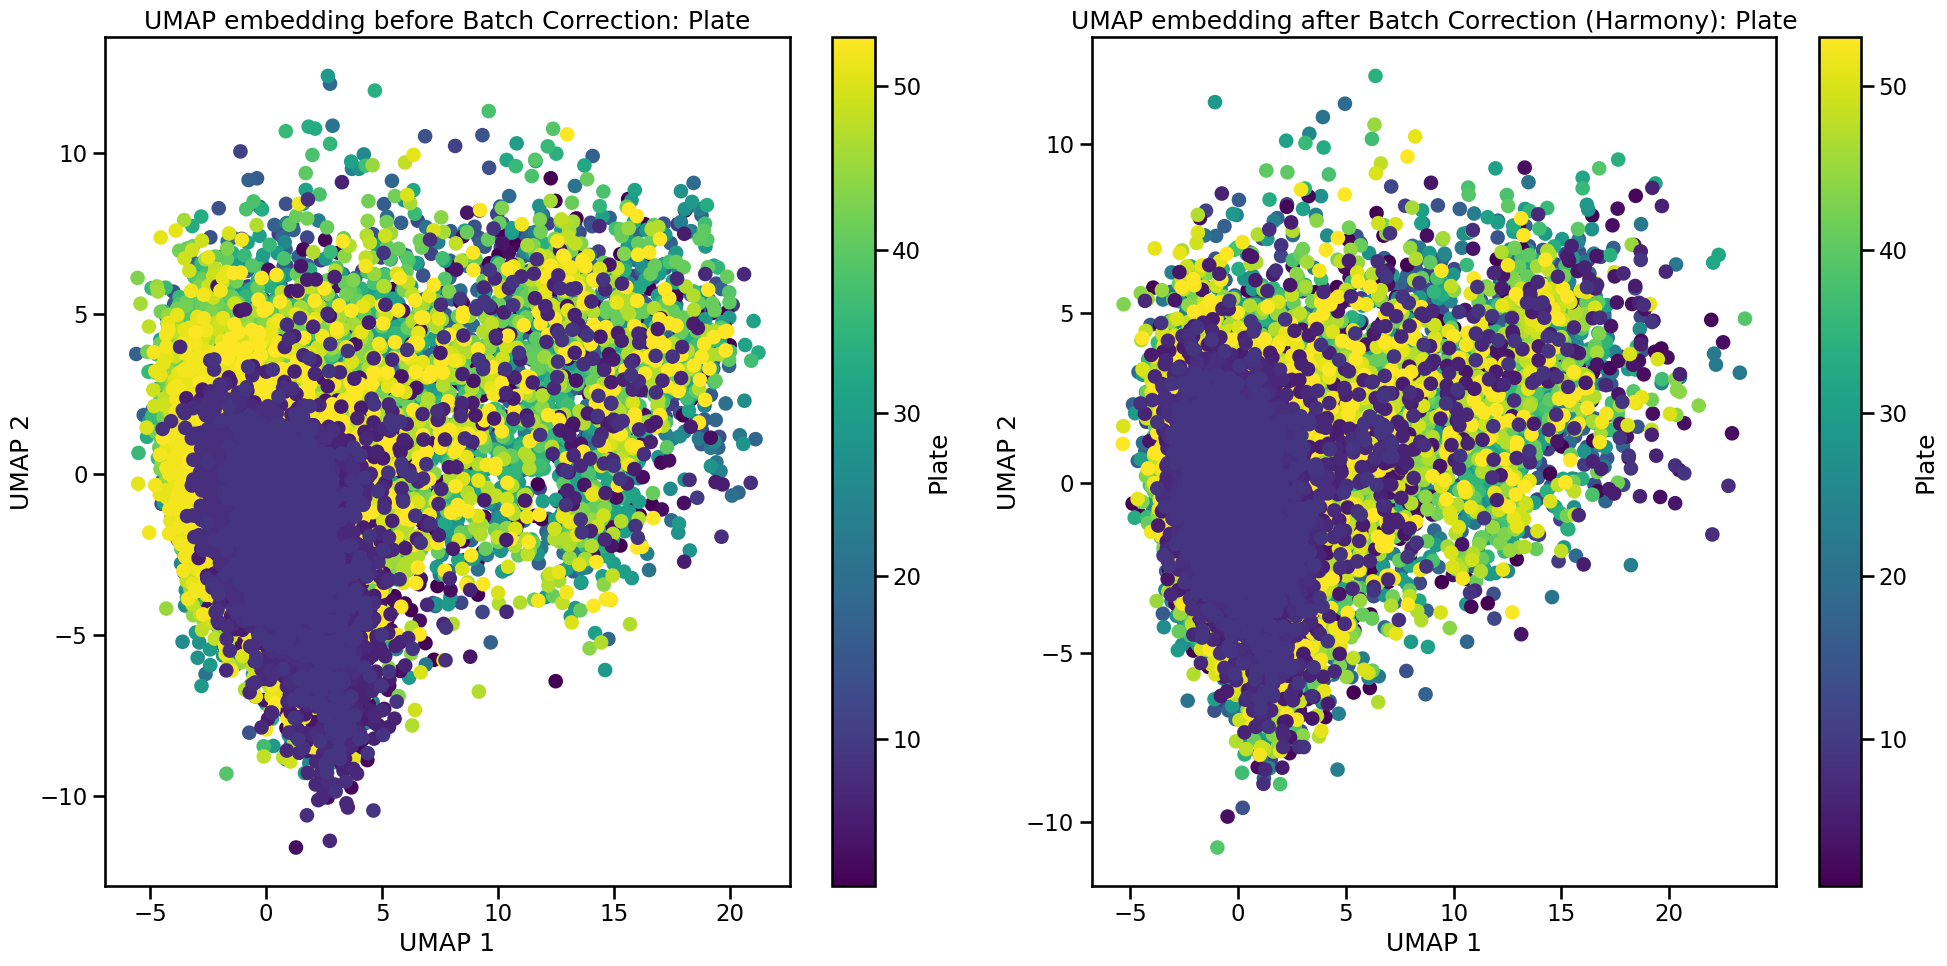

In [12]:
# Get the Harmony embedding from adata.obsm
harmony_embedding = adata.obsm["Harmony"]

# Create a new figure and axes for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot UMAP before batch correction with labels
ax1.scatter(adata.obsm["Unintegrated"][:, 0], adata.obsm["Unintegrated"][:, 1], c=adata.obs["plate"], cmap="viridis")
ax1.set_title("UMAP embedding before Batch Correction: Plate")
ax1.set_xlabel("UMAP 1")
ax1.set_ylabel("UMAP 2")
# Add colorbar for plate information
cbar1 = plt.colorbar(ax1.collections[0], ax=ax1)
cbar1.set_label("Plate")

# Plot UMAP after batch correction using Harmony with labels
ax2.scatter(harmony_embedding[:, 0], harmony_embedding[:, 1], c=adata.obs["plate"], cmap="viridis")
ax2.set_title("UMAP embedding after Batch Correction (Harmony): Plate")
ax2.set_xlabel("UMAP 1")
ax2.set_ylabel("UMAP 2")
# Add colorbar for plate information
cbar2 = plt.colorbar(ax2.collections[0], ax=ax2)
cbar2.set_label("Plate")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


We see that after batch correction the inter-plate batch effect does seem to be reduced a little bit.